In [1]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import time

In [2]:
def substract(list1,list2):
    return [x-y for (x,y) in zip(list1,list2)]

### Optimization Problem with linear cost - Non-cooperative and asymmetric scenario

$$ \min_{\lambda_n}\frac{1}{\mu_n}\left(\frac{\mu_n+\lambda}{\lambda_n}+c\lambda_n\right),\qquad n=1,2,\ldots,K\qquad\lambda=\lambda_1+\cdots+\lambda_K$$

#### First order conditions

$$c\lambda_n^2+\lambda_n-(\mu_n+\lambda)=0,\qquad n=1,2,\ldots,K$$

##### Fixeed -Point Algorithm

Set $\lambda_n^0$ and compute iteratively

$$\lambda_n^r=\sqrt{\dfrac{\mu_n+\lambda_{-n}^{r-1}}{c}},\qquad n=1,2,\cdots,K$$
until some kind of convergence.

In [3]:
def AlgApproxNE(c,serv,itermax=1000):
    ''' Numeric computation of the optimal generation rates in 
        decentralized scenario
        
        INPUT
        c      : cost for server usage
        serv   : service rates
        itermax: maximum number of iterations
        
        OUTPUT
        Lambdas: optimal generation rates at the Nash Equilibrium
    '''
    
    K = len(serv)
    Lambdas = dict()
    Lambdas[0] = [0]*K
    for n in range(K):
        Lambdas[0][n] = rd.randint(1,round(serv[n]+1)*15)/10
    delta_min = 10**(-23)
    delta = 1; r = 0
    while r<=itermax and delta>delta_min:
        r += 1
        lamb = sum(Lambdas[r-1][:K])
        Lambdas[r] = [0]*(K+1)
        for n in range(K):
            Lambdas[r][n] = np.sqrt((serv[n]+lamb-Lambdas[r-1][n])/c)
        diff  = substract(Lambdas[r][:K],Lambdas[r-1][:K])
        delta = np.linalg.norm(diff,2)
        Lambdas[r][K] = delta
    return Lambdas

### Optimization Problem with linear cost - Cooperative and asymmetric scenario

$$ \min_{\lambda_n}\sum\limits_{n=1}^{K}\frac{1}{\mu_n}\left(\frac{\mu_n+\lambda}{\lambda_n}+c\lambda_n\right)\qquad\lambda=\lambda_1+\cdots+\lambda_K$$

#### First order conditions

$$c\lambda_n^2+\sum\limits_{m=1}^K\dfrac{\mu_n\lambda_n^2}{\mu_m\lambda_m}-(\mu_n+\lambda)=0,\qquad n=1,2,\ldots,K$$

##### Fixeed -Point Algorithm

Set $\lambda_n^0$ and compute iteratively

$$\lambda_n^r=\sqrt{\dfrac{\mu_n+\lambda_{-n}^{r-1}}{c+\mu_n\sum\limits_{m\ne n}\dfrac{1}{\mu_m\lambda_m^{r-1}}}},\qquad n=1,2,\cdots,K$$
until some kind of convergence.

In [4]:
def AlgApproxG(c,serv,itermax=1000):
    ''' Numeric computation of the optimal generation rates in 
        centralized scenario
        
        INPUT
        c      : cost for server usage
        serv   : service rates
        itermax: maximum number of iterations
        
        OUTPUT
        Lambdas: optimal generation rates at the global optimum
    '''
    
    K = len(serv)
    Lambdas = dict()
    Lambdas[0] = [0]*K
    for n in range(K):
        Lambdas[0][n] = rd.randint(1,round(serv[n]+1)*15)/10
    delta_min = 10**(-18)
    delta = 1; r = 0
    while r<=itermax and delta>delta_min:
        r += 1
        lamb = sum(Lambdas[r-1][:K])
        lamb_1 = sum(
            [1/(serv[m]*Lambdas[r-1][m]) for m in range(K)])
        Lambdas[r] = [0]*(K+1)
        for n in range(K):
            num = serv[n] + lamb - Lambdas[r-1][n]
            den = c + serv[n]*(lamb_1 - (1/serv[n]/Lambdas[r-1][n]))
            Lambdas[r][n] = np.sqrt(num/den)
        diff = substract(Lambdas[r][:K],Lambdas[r-1][:K])
        delta = np.linalg.norm(diff,2)
        Lambdas[r][K] = delta
    return Lambdas

In [5]:
def ObjFunct(n,arriv,serv,c):
    ''' Assess the value of cost function for source n 
    
        INPUT
        n    : source index
        arriv: generation rates
        serv : service rates
        c    : trasnmission cost
        
        OUTPUT
        Cost function of source n
    '''
    
    mu_n   = serv[n]
    lamb_n = arriv[n]
    lamb   = sum(arriv)
    s1 = (mu_n + lamb)/mu_n/lamb_n
    s2 = c*lamb_n/mu_n
    return s1+s2

In [6]:
def ObjFunctGen(arriv,serv,c):
    ''' Assess the value of the aggregate cost function 
    
        INPUT
        arriv: generation rates
        serv : service rates
        c    : trasnmission cost
        
        OUTPUT
        Global cost
    '''
    
    K = len(serv)
    OF = 0
    for n in range(K):
        OF += ObjFunct(n,arriv,serv,c)
    return OF

In [7]:
def PriceofAnarchy(lamb_ne,lamb_g,serv,c):
    ''' INPUT
        lamb_ne: optimal arrival rates for Nash Equilibrium
        lamb_g : optimal arrival rates for Global Equilibrium
        serv   : service rates
        c      : transmission cost
     
        OUTPUT
        Ratio between the total cost at Nash equilibrium and total cost at the global optimum.
    '''
    
    OF_ne = ObjFunctGen(lamb_ne,serv,c)
    OF_g  = ObjFunctGen(lamb_g,serv,c)
    return OF_ne/OF_g

In [8]:
def config1(M,K):
    ''' INPUT
        M : range of service rates
        K : number of sources
    
        OUTPUT
        Service rates of CF1 in Section 3.5 and transmission cost c_sym
    '''
    
    serv = [0]*K
    for n in range(K-1):
        serv[n] = M-n
    serv[K-1] = 1
    
    cost   = K*sum([1/serv[n] for n in range(K)])
    return serv,cost

In [9]:
def config2(M,K):
    ''' INPUT
        M : range of service rates
        K : number of sources
    
        OUTPUT
        Service rates of CF2 in Section 3.5 and transmission cost c_sym
    '''
    
    serv = [0]*K
    for n in range(K):
        serv[n] = M - (M-1)*n/(K-1)
    serv[K-1] = 1
    
    cost   = K*sum([1/serv[n] for n in range(K)])
    return serv,cost

In [10]:
def PoA_Evolution(Mmax,K,cf=1):
    ''' INPUT
        Mmax: positive real number
        K   : vector of number of sources
        cf  : service rate configuration (1 or 2)
    
        OUTPUT
        Dictionary with PoA evolution across 100<=M<=Mmax for each k<=K 
    '''
    
    if cf==1:
        serv_funct = config1
    if cf==2:
        serv_funct = config2
    PoA = dict() 
    for k in K:
        rangeM = np.linspace(100,Mmax,100)
        PoA[k] = np.empty_like(rangeM)

        for n in range(len(rangeM)):
            M = rangeM[n]
            serv,csym  = serv_funct(M,k)
            Lambdas_ne = AlgApproxNE(csym,serv)
            lamb_ne    = Lambdas_ne[len(Lambdas_ne)-1][:-1]
            Lambdas_g  = AlgApproxG(csym,serv)
            lamb_g     = Lambdas_g[len(Lambdas_g)-1][:-1]
            PoA[k][n]  = PriceofAnarchy(lamb_ne,lamb_g,serv,csym)
    return PoA

In [11]:
K = [2,6,10]; Mmax = 1000**2
PoA1 = PoA_Evolution(Mmax,K)
PoA2 = PoA_Evolution(Mmax,K,cf=2)

In [12]:
rangeM = np.linspace(100,Mmax,100)
colors = ['red','green','blue']
styles = ['-','--',':']
K      = list(PoA1.keys())

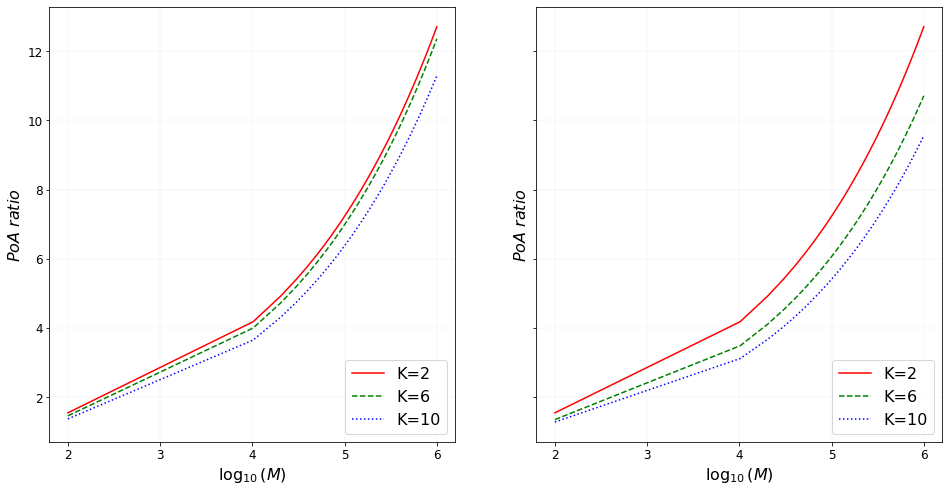

In [19]:
#
#     Figure 3.2, Section 3.5 "Numerical Experiments" in 
#     "Price of Anarchy with Multiple Information Sources under Competition"
#

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,8), sharex=True, sharey=True)
for k in range(len(K)):
    ax1.plot(np.log10(rangeM), PoA1[K[k]], 
            color=colors[k], ls=styles[k], 
            label='K=%i'%(K[k]))
    ax2.plot(np.log10(rangeM), PoA2[K[k]], 
            color=colors[k], ls=styles[k], 
            label='K=%i'%(K[k]))
ax1.set_xlabel(r'$\log_{10}(M)$', fontsize=16)
ax1.set_ylabel(r'$PoA\ ratio$', fontsize=16)
ax1.set_xticks(np.arange(2,7))
ax1.tick_params(labelsize=12)
ax1.grid(color='lightgray',ls = '-.',lw = 0.25)
ax1.legend(loc='lower right',fontsize=16)
ax2.set_xlabel(r'$\log_{10}(M)$', fontsize=16)
ax2.set_ylabel(r'$PoA\ ratio$', fontsize=16)
ax2.set_xticks(np.arange(2,7))
ax2.tick_params(labelsize=12)
ax2.grid(color='lightgray',ls = '-.',lw = 0.25)
ax2.legend(loc='lower right',fontsize=16)
plt.show()
fig.savefig('..\..\Thesis\chapter3\img\poa_ratio2.png')